Estimated recurrence parameters: a = 2431.426481, b = -1.726751

Estimated S_inf from power-law: 6.266e+44

Ratios between successive scenario totals:
Scenario 2 / Scenario 1: 1.784534
Scenario 3 / Scenario 2: 1.373739
Scenario 4 / Scenario 3: 1.279506
Scenario 5 / Scenario 4: 1.265798
Scenario 6 / Scenario 5: 1.281593
Scenario 7 / Scenario 6: 1.310039

Extrapolated scenario_ratio_infinity ≈ 1.274099
Adjusted S_inf and estimated number of legal chess positions ≈ 4.918e+44


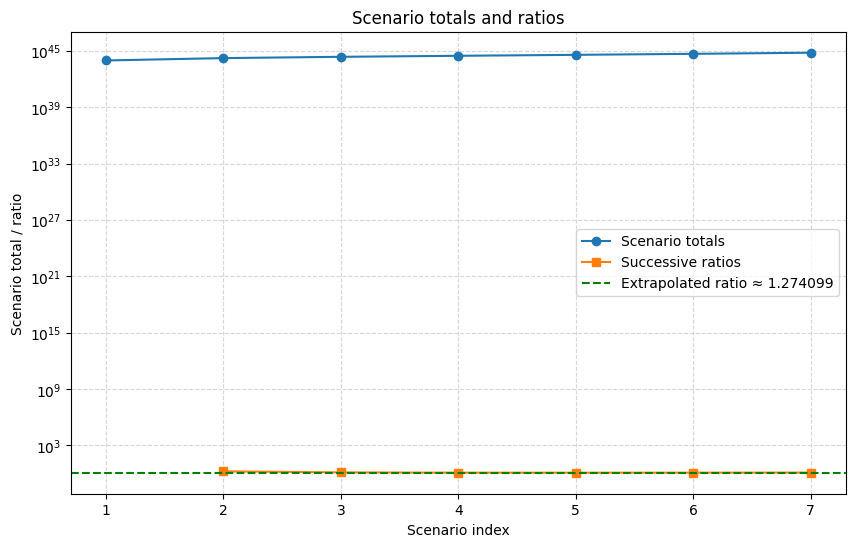

In [ ]:
# Joshua Tutin and ChatGPT estimating number of legal chess positions
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import zeta

# --- Tablebase data: T2..T8 ---
TableBaseData = terms = np.array([
    462, 368079, 125246598, 25912594054,
    3787154440416, 423836835667331, 38176306877748245
])

# --- Cumulative terms to match previous code ---
terms = np.array([
    462,
    462 + 368079,
    462 + 368079 + 125246598,
    462 + 368079 + 125246598 + 25912594054,
    462 + 368079 + 125246598 + 25912594054 + 3787154440416,
    462 + 368079 + 125246598 + 25912594054 + 3787154440416 + 423836835667331,
    462 + 368079 + 125246598 + 25912594054 + 3787154440416 + 423836835667331 + 38176306877748245
])

# --- Compute ratios of consecutive terms ---
ratios = terms[1:] / terms[:-1]
n_values = np.arange(2, 8)  # indices for ratios

# --- Log-log regression to get a, b ---
log_ratios = np.log(ratios)
log_n = np.log(n_values)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_n, log_ratios)
a = np.exp(intercept)
b = slope
print(f"Estimated recurrence parameters: a = {a:.6f}, b = {b:.6f}")

# --- Recurrence sequence generator ---
def recurrence_sequence(a, b, known_terms, n_start, n_end):
    seq = list(known_terms)
    last_term = seq[-1]
    n_current = n_start + len(known_terms) - 1
    for i, n in enumerate(range(n_current + 1, n_end + 1)):
        ratio = a * (n_current ** b) if i == 0 else a * (n ** b)
        last_term *= ratio
        seq.append(last_term)
    return np.array(seq)

# --- Generate scenarios ---
scenario_totals = []
all_predictions = []

for k in range(1, len(terms)+1):
    known = terms[:k]
    predicted = recurrence_sequence(a, b, known, n_start=2, n_end=32)
    scenario_totals.append(predicted.sum())
    all_predictions.append(predicted)

scenario_totals = np.array(scenario_totals)
scenario_indices = np.arange(1, len(scenario_totals)+1)

# --- Differences between successive totals ---
diffs = np.diff(scenario_totals)
k_fit = np.arange(1, len(diffs)+1)

# --- Power-law fit to differences ---
def power_law(k, C, p):
    return C / k**p

params, cov = curve_fit(power_law, k_fit, diffs, p0=[diffs[0], 1.5])
C_fit, p_fit = params
S_inf_est = scenario_totals[-1] + C_fit * zeta(p_fit)
print(f"\nEstimated S_inf from power-law: {S_inf_est:.3e}")

# --- Compute ratios between scenario totals ---
scenario_ratios = scenario_totals[1:] / scenario_totals[:-1]
print("\nRatios between successive scenario totals:")
for i, r in enumerate(scenario_ratios, start=1):
    print(f"Scenario {i+1} / Scenario {i}: {r:.6f}")

# --- Extrapolate scenario ratios to infinity ---
def ratio_decay_model(k, R_inf, C, p):
    return R_inf + C / k**p

k_for_ratios = np.arange(1, len(scenario_ratios)+1)
try:
    params_ratio, _ = curve_fit(ratio_decay_model, k_for_ratios, scenario_ratios,
                                p0=[0.5, 0.5, 1.0], maxfev=5000)
    R_inf_fit, C_fit_ratio, p_fit_ratio = params_ratio
    print(f"\nExtrapolated scenario_ratio_infinity ≈ {R_inf_fit:.6f}")
except:
    R_inf_fit = scenario_ratios[-1]
    print("\nExtrapolation failed, using last ratio as scenario_ratio_infinity")

# --- Adjust S_inf using extrapolated ratio ---
if R_inf_fit is not None and R_inf_fit != 0:
    S_inf_adjusted = S_inf_est / R_inf_fit
    print(f"Adjusted S_inf and estimated number of legal chess positions ≈ {S_inf_adjusted:.3e}")
else:
    S_inf_adjusted = S_inf_est


# --- Optional plots ---
plt.figure(figsize=(10,6))
plt.plot(scenario_indices, scenario_totals, 'o-', label='Scenario totals')
plt.plot(k_for_ratios + 1, scenario_ratios, 's-', label='Successive ratios')
plt.axhline(R_inf_fit, color='g', linestyle='--', label=f"Extrapolated ratio ≈ {R_inf_fit:.6f}")
plt.yscale('log')
plt.xlabel("Scenario index")
plt.ylabel("Scenario total / ratio")
plt.title("Scenario totals and ratios")
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.show()